In [1]:
import pandas as pd
from statsmodels.multivariate.pca import PCA
import dcor
import seaborn as sns
import matplotlib.pyplot as plt

from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, Legend
from bokeh.palettes import Spectral6, Dark2, inferno
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
from bokeh.models import Range1d

import pickle
import os.path
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request

output_notebook()

Loading BokehJS ...

# Load data

In [16]:
SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']
SPREADSHEET_ID = '1oBcTHFHMJqFgzIMdROsdDJ3B8o2-FUDOIdJjMnhxPZY'
RANGE = 'wodlog!A:AG'

# Get credentials
creds = None
if os.path.exists('token.pickle'):
    with open('/Users/hasannagib/Documents/gsheet_api/token.pickle', 'rb') as token:
        creds = pickle.load(token)
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file(
            '/Users/hasannagib/Documents/gsheet_api/autowod_creds.json', SCOPES)
        creds = flow.run_local_server(port=0)
    with open('/Users/hasannagib/Documents/gsheet_api/token.pickle', 'wb') as token:
        pickle.dump(creds, token)

# Get data
service = build('sheets', 'v4', credentials=creds)
sheet = service.spreadsheets()
result = sheet.values().get(
    spreadsheetId=SPREADSHEET_ID,
    range=RANGE
).execute()
values = result.get('values', [])

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=130515744428-6in65u9i9vhickestc850on3peqmlc7u.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A56816%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fspreadsheets.readonly&state=PypKcFAXuCRF8jt3gZlHQvfGhSbMHL&access_type=offline


In [17]:
df = pd.DataFrame(values[1:], columns=values[0]).fillna(0).replace('',0)
df = df.astype({
    'day':int,
    'ex':object,
    'wt':float, 
    'rep':float,
    'group':float,
    'duration':float,
    'dist(m)':float,
    'cals':float,
    'emom':float,
    'tabata':int,
    'work':float,
    'rest':float,
    'deathby':float,
    'master':float,
    'time':float,
    'task':float,
    'gymnastics':float,
    'mmetcon':float,
    'wtlft':float,
    'bilateral':float, 
    'unilateral':float, 
    'push':float,
    'pull':float, 
    'chest':float, 
    'back':float, 
    'shoulder':float, 
    'bi':float, 
    'tri':float, 
    'quad':float, 
    'ham':float, 
    'hip':float,
    'core':float, 
}
)
df['vol'] = df['wt']*df['rep']
df = df.set_index(['ex', 'day', 'dt', 'wt', 'rep'])
df = df.multiply(df['vol'], axis='index').drop(columns=['group', 'vol'])

In [18]:
# modality & muscle groups only
df = df.iloc[:, 8:]

# modality and workout styles only
#df = df.iloc[:, :11]

df = df.groupby(['day', 'ex']).sum()
df.columns

Index(['master', 'time', 'task', 'gymnastics', 'mmetcon', 'wtlft', 'bilateral',
       'unilateral', 'push', 'pull', 'chest', 'back', 'shoulder', 'bi', 'tri',
       'quad', 'ham', 'hip', 'core'],
      dtype='object')

# Compare pairwise WOD `dCorr` values

In [19]:
cors = []
for i in range(df.index.max()[0]+1):
    for j in range(df.index.max()[0]+1):
        cor = dcor.distance_correlation(
            df.query(f'day=={i}').T, 
            df.query(f'day=={j}').T
        )
    
        cors.append([i, j, cor])
        
df_corr = pd.DataFrame(cors, columns=['day_A', 'day_B', 'corr'])
df_corr = df_corr.set_index(['day_A', 'day_B']).reset_index()

## Visualizing WOD Similarity

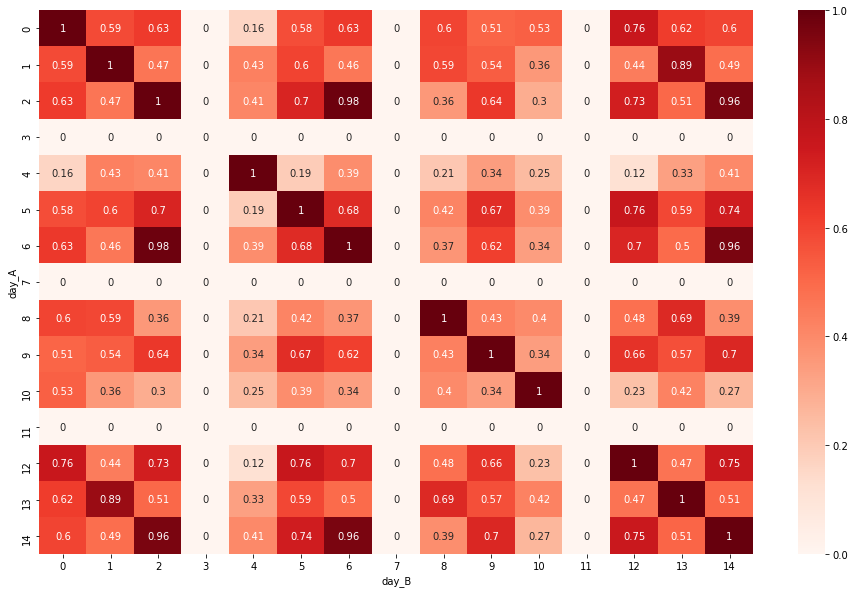

In [20]:
plt.figure(figsize=(16,10))
sns.heatmap(df_corr.pivot('day_A', 'day_B', 'corr'), cmap="Reds", annot=True);

### Interpreting the heatmap

The matrix above shows similarity among pairwise WODs. 1 being identical and 0 being least similar (or rest days). e.g. If we consider the bottom row, and read it from right to left, we see that day 12 has very little in common with day 8,9,10. But it is pretty close to day 5 & 6. Let's see if this makes intuitive sense or not by examining the WODs from those days...

In [21]:
df.query('day==14')

master  time    task  gymnastics  \
day ex                                                                    
14  alternating reverse goblet lunges     0.0   0.0  1000.0         0.0   
    deadlifts                             0.0   0.0  4050.0         0.0   
    dumbbell hang power snatch            0.0   0.0   600.0         0.0   
    front squats                          0.0   0.0  2700.0         0.0   
    hang power cleans                     0.0   0.0  1350.0         0.0   
    human makers                          0.0   0.0   300.0         0.0   
    one arm kettlebell snatches           0.0   0.0   500.0         0.0   
    push up plank sliders                 0.0   0.0    30.0        30.0   
    russian kettlebell swing              0.0   0.0  1500.0         0.0   
    strict handstand push ups             0.0   0.0    10.0        10.0   
    toes to bar                           0.0   0.0    20.0        20.0   
    weighted box step over                0.0   0.0   900.0         0.0   

                                       mmetcon   wtlft  bilateral  unilateral  \
day ex                                                                          
14  alternating reverse goblet lunges      0.0  1000.0        0.0      1000.0   
    deadlifts                              0.0  4050.0     4050.0         0.0   
    dumbbell hang power snatch             0.0   600.0        0.0       600.0   
    front squats                           0.0  2700.0     2700.0         0.0   
    hang power cleans                      0.0  1350.0     1350.0         0.0   
    human makers                           0.0   300.0      300.0       300.0   
    one arm kettlebell snatches            0.0   500.0        0.0       500.0   
    push up plank sliders                  0.0     0.0       30.0         0.0   
    russian kettlebell swing               0.0  1500.0     1500.0         0.0   
    strict handstand push ups              0.0     0.0       10.0         0.0   
    toes to bar                            0.0     0.0       20.0         0.0   
    weighted box step over                 0.0   900.0        0.0       900.0   

                                        push    pull  chest    back  shoulder  \
day ex                                                                          
14  alternating reverse goblet lunges    0.0     0.0    0.0     0.0       0.0   
    deadlifts                            0.0  4050.0    0.0  4050.0       0.0   
    dumbbell hang power snatch           0.0   600.0    0.0     0.0     600.0   
    front squats                         0.0     0.0    0.0     0.0       0.0   
    hang power cleans                    0.0  1350.0    0.0  1350.0       0.0   
    human makers                       300.0   300.0  300.0   300.0     300.0   
    one arm kettlebell snatches          0.0   500.0    0.0     0.0     500.0   
    push up plank sliders               30.0     0.0   30.0     0.0      30.0   
    russian kettlebell swing             0.0     0.0    0.0  1500.0       0.0   
    strict handstand push ups           10.0     0.0    0.0     0.0      10.0   
    toes to bar                          0.0     0.0    0.0     0.0       0.0   
    weighted box step over               0.0     0.0    0.0     0.0       0.0   

                                          bi    tri    quad     ham     hip  \
day ex                                                                        
14  alternating reverse goblet lunges    0.0    0.0  1000.0  1000.0  1000.0   
    deadlifts                            0.0    0.0  4050.0  4050.0  4050.0   
    dumbbell hang power snatch           0.0    0.0   600.0     0.0     0.0   
    front squats                         0.0    0.0  2700.0  1350.0  1350.0   
    hang power cleans                    0.0    0.0  1350.0  1350.0  1350.0   
    human makers                       300.0  300.0   300.0   300.0   300.0   
    one arm kettlebell snatches          0.0    0.0     0.0   500.0   500.0   
    pus

In [8]:
df.query('day==6')

master  time    task  gymnastics  mmetcon  \
day ex                                                                       
6   back squat                      0.0   0.0  4025.0         0.0      0.0   
    back to wall handstand hold     0.0   0.0     0.0        10.0      0.0   
    deadlifts                       0.0   0.0  4600.0         0.0      0.0   
    double unders                   0.0   0.0     0.0         0.0    250.0   
    front squats                    0.0   0.0  4025.0         0.0      0.0   
    hang power cleans               0.0   0.0  4025.0         0.0      0.0   
    push press                      0.0   0.0  4025.0         0.0      0.0   

                                  wtlft  bilateral  unilateral    push  \
day ex                                                                   
6   back squat                   4025.0     4025.0         0.0     0.0   
    back to wall handstand hold     0.0        0.0         0.0     0.0   
    deadlifts                    4600.0     4600.0         0.0     0.0   
    double unders                   0.0      250.0         0.0     0.0   
    front squats                 4025.0     4025.0         0.0     0.0   
    hang power cleans            4025.0     4025.0         0.0     0.0   
    push press                   4025.0     4025.0         0.0  4025.0   

                                   pull  chest    back  shoulder   bi  tri  \
day ex                                                                       
6   back squat                      0.0    0.0     0.0       0.0  0.0  0.0   
    back to wall handstand hold     0.0    0.0     0.0       0.0  0.0  0.0   
    deadlifts                    4600.0    0.0  4600.0       0.0  0.0  0.0   
    double unders                   0.0    0.0     0.0       0.0  0.0  0.0   
    front squats                    0.0    0.0     0.0       0.0  0.0  0.0   
    hang power cleans            4025.0    0.0  4025.0       0.0  0.0  0.0   
    push press                      0.0    0.0     0.0    4025.0  0.0  0.0   

                                   quad     ham     hip  core  
day ex                                                         
6   back squat                   4025.0  4025.0  4025.0   0.0  
    back to wall handstand hold     0.0     0.0     0.0   0.0  
    deadlifts                    4600.0  4600.0  4600.0   0.0  
    double unders                   0.0     0.0     0.0   0.0  
    front squats                 4025.0  2012.5  2012.5   0.0  
    hang power cleans            4025.0  4025.0  4025.0   0.0  
    push press                   4025.0     0.0  4025.0   0.0

In [22]:
df.query('day==10')

master  time  task  gymnastics  mmetcon  \
day ex                                                                         
10  arnold press                        0.0   0.0   0.0         0.0      0.0   
    bench press                         0.0   0.0   0.0         0.0      0.0   
    crossbody mountain climber          0.0   0.0   0.0       240.0      0.0   
    decline dumbbell bench press        0.0   0.0   0.0         0.0      0.0   
    decline stability ball push ups     0.0   0.0   0.0        40.0      0.0   
    eccentric handstand push ups        0.0   0.0   0.0        20.0      0.0   
    pike press                          0.0   0.0   0.0        20.0      0.0   
    six direction shoulder fly          0.0   0.0   0.0         0.0      0.0   
    stability ball push ups             0.0   0.0   0.0        40.0      0.0   
    stair climb                         0.0   0.0   0.0         0.0    201.0   

                                      wtlft  bilateral  unilateral    push  \
day ex                                                                       
10  arnold press                      600.0      600.0         0.0   600.0   
    bench press                      5400.0     5400.0         0.0  5400.0   
    crossbody mountain climber          0.0        0.0       240.0     0.0   
    decline dumbbell bench press     1200.0     1200.0         0.0     0.0   
    decline stability ball push ups     0.0       40.0         0.0    40.0   
    eccentric handstand push ups        0.0       20.0         0.0    20.0   
    pike press                          0.0       20.0         0.0    20.0   
    six direction shoulder fly        250.0      250.0         0.0     0.0   
    stability ball push ups             0.0       40.0         0.0    40.0   
    stair climb                         0.0        0.0         0.0     0.0   

                                     pull   chest  back  shoulder   bi  \
day ex                                                                   
10  arnold press                      0.0     0.0   0.0     600.0  0.0   
    bench press                       0.0  5400.0   0.0       0.0  0.0   
    crossbody mountain climber        0.0     0.0   0.0       0.0  0.0   
    decline dumbbell bench press      0.0  1200.0   0.0    1200.0  0.0   
    decline stability ball push ups   0.0    40.0   0.0      40.0  0.0   
    eccentric handstand push ups      0.0     0.0   0.0      20.0  0.0   
    pike press                        0.0     0.0   0.0      20.0  0.0   
    six direction shoulder fly        0.0     0.0   0.0     250.0  0.0   
    stability ball push ups           0.0    40.0   0.0      40.0  0.0   
    stair climb                       0.0     0.0   0.0       0.0  0.0   

                                        tri   quad    ham    hip   core  
day ex                                                                   
10  arnold press                        0.0    0.0    0.0    0.0    0.0  
    bench press                         0.0    0.0    0.0    0.0    0.0  
    crossbody mountain climber          0.0    0.0    0.0    0.0  240.0  
    decline dumbbell bench press     1200.0    0.0    0.0    0.0    0.0  
    decline stability ball push ups    40.0    0.0    0.0    0.0    0.0  
    eccentric handstand push ups       20.0    0.0    0.0    0.0    0.0  
    pike press                          0.0    0.0    0.0    0.0    0.0  
    six direction shoulder fly          0.0    0.0    0.0    0.0    0.0  
    stability ball push ups            40.0    0.0    0.0    0.0    0.0  
    stair climb                         0.0  201.0  201.0  201.0    0.0

## Comparing multiple WODs

We can also compare workout from one day to multiple other days. Or one week to another week.

In [10]:
# comparing day 12 against days 0,1,2,4,5,6
dcor.distance_correlation(
    df.query(f'day in (0,1,2,4,5,6)').T, 
    df.query(f'day in (12,)').T
)

0.8236997539726517

In [11]:
dcor.distance_correlation(
    df.query(f'day in (0,1,2)').T, 
    df.query(f'day in (4,5,6)').T
)

0.837624810024915

In [12]:
dcor.distance_correlation(
    df.query(f'day in (0,1,2)').T, 
    df.query(f'day in (8,9,10)').T
)

0.6691414912108686

In [13]:
dcor.distance_correlation(
    df.query(f'day in (4,5,6)').T, 
    df.query(f'day in (8,9,10)').T
)

0.690960419935475

In [14]:
dcor.distance_correlation(
    df.query(f'day in (12,13,14)').T, 
    df.query(f'day in (8,9,10)').T
)

0.665828002736378